# News Sentiment Trading Strategy
### This notebook analyzes how news sentiment correlates with stock price movements and tests trading strategies based on sentiment signals.


In [13]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests_cache
import os
from datetime import datetime, timedelta
import seaborn as sns

api_token = os.environ.get('EODHD_API_TOKEN')
requests_cache.install_cache('cache')

TICKER = 'AAPL.US'
# Using a 2-year period for analysis
end_date = datetime.now()
start_date = end_date - timedelta(days=730)
from_date = start_date.strftime('%Y-%m-%d')
to_date = end_date.strftime('%Y-%m-%d')

# Retrieving Price Data
### Function to fetch historical stock price data from EODHD API and prepare it for analysis.


In [14]:
def get_price_data(ticker, from_date, to_date):
    url = f'https://eodhd.com/api/eod/{ticker}'
    query = {'api_token': api_token, 'fmt': 'json', 'from': from_date, 'to': to_date}
    response = requests.get(url, params=query)

    if response.status_code != 200:
        print(f"Error retrieving price data: {response.status_code}")
        print(response.text)
        return None

    price_data = response.json()
    price_df = pd.DataFrame(price_data)

    # Convert date string to datetime for easier manipulation
    price_df['date'] = pd.to_datetime(price_df['date'])
    # Set date as index
    price_df.set_index('date', inplace=True)
    # Sort by date (ascending)
    price_df.sort_index(inplace=True)

    return price_df

price_df = get_price_data(TICKER, from_date, to_date)
price_df['pct_change'] = price_df['adjusted_close'].pct_change() * 100
price_df.head()

,open,high,low,close,adjusted_close,volume,pct_change
date,,,,,,,
2023-05-11,173.85,174.59,172.17,173.75,172.0153,49514700,NaN
2023-05-12,173.62,174.06,171.00,172.57,171.0834,45497800,-0.541754
2023-05-15,173.16,173.21,171.47,172.07,170.5877,37266700,-0.289742
2023-05-16,171.99,173.14,171.80,172.07,170.5877,42110300,0.000000
2023-05-17,171.71,172.93,170.42,172.69,171.2023,57951600,0.360284


# Retrieving Sentiment Data
### Function to fetch news sentiment data from EODHD API and process it for analysis.


In [15]:
def get_sentiment_data(ticker, from_date, to_date):
    url = f'https://eodhd.com/api/sentiments'
    query = {'api_token': api_token, 's': ticker, 'from': from_date, 'to': to_date, 'fmt': 'json'}
    response = requests.get(url, params=query)

    if response.status_code != 200:
        print(f"Error retrieving sentiment data: {response.status_code}")
        print(response.text)
        return None

    sentiment_data = response.json()
    # Access the sentiment data using the ticker symbol as a key
    sentiment_df = pd.DataFrame(sentiment_data[ticker])

    # Convert date string to datetime
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    # Set date as index
    sentiment_df.set_index('date', inplace=True)
    # Sort by date (ascending)
    sentiment_df.sort_index(inplace=True)

    # Rename column normalized to sentiment
    sentiment_df.rename(columns={'normalized': 'sentiment'}, inplace=True)

    return sentiment_df

sentiment_df = get_sentiment_data(TICKER, from_date, to_date)

sentiment_df.head()

,count,sentiment
date,,
2023-05-11,15,0.5235
2023-05-12,16,0.3802
2023-05-13,3,0.6870
2023-05-14,5,0.8038
2023-05-15,14,0.6574


# Merging and Cleaning Data
### Combines price and sentiment data, removes outliers, and prepares dataset for analysis.


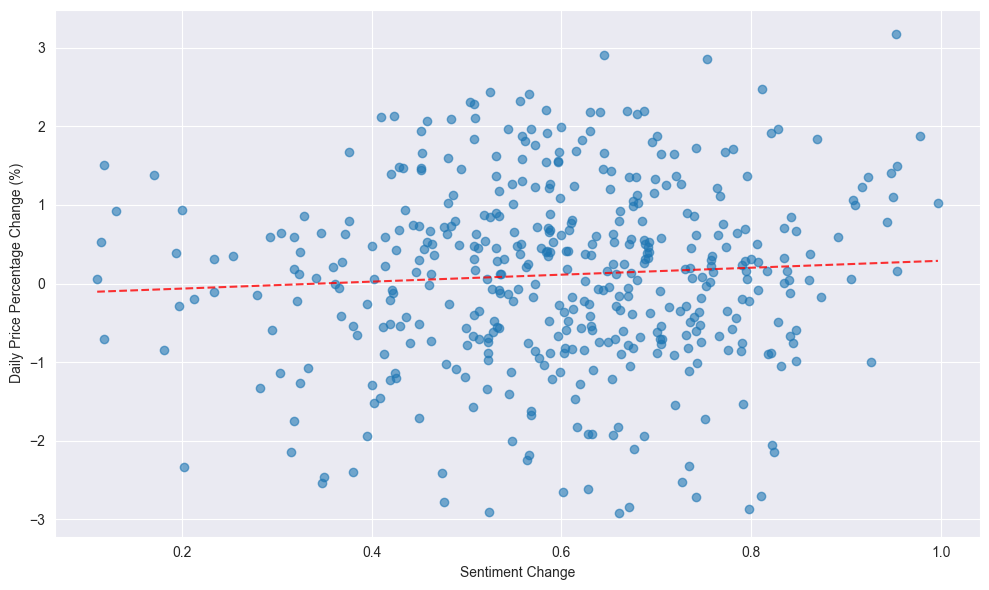

In [16]:
merged_df = pd.merge(
    price_df[['adjusted_close','pct_change']],
    sentiment_df[['sentiment']],
    left_index=True,
    right_index=True,
    how='inner'
)

# Rename columns for clarity
merged_df.columns = ['price', 'price_pct_change', 'sentiment']

clean_df = merged_df[['price_pct_change','sentiment']].dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Calculate IQR and bounds for both variables
def remove_outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[df_clean[column].between(lower_bound, upper_bound)]
    return df_clean

# Apply outlier removal
clean_df = remove_outliers(clean_df, ['price_pct_change', 'sentiment'])

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(clean_df['sentiment'], clean_df['price_pct_change'], alpha=0.6)
plt.xlabel('Sentiment Change')
plt.ylabel('Daily Price Percentage Change (%)')
plt.grid(True)

# Add a trend line
if len(clean_df) > 1:  # Only add trend line if we have enough data points
    try:
        z = np.polyfit(clean_df['sentiment'], clean_df['price_pct_change'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(clean_df['sentiment']), p(sorted(clean_df['sentiment'])), "r--", alpha=0.8)
    except np.linalg.LinAlgError as e:
        print(f"Could not fit trend line: {e}")

plt.tight_layout()
plt.show()

# Equity Curve Calculation
### Function to calculate cumulative returns based on price data and trading signals.


In [17]:
def calculate_equity_curve(prices, signals):
    # Ensure index alignment
    signals = signals.shift(1)  # Shift signals to align with the period for trade execution
    signals = signals.reindex(prices.index).fillna(0)

    # Calculate percentage changes
    pct_changes = prices.pct_change().fillna(0)

    # Calculate equity curve
    equity_curve = (1 + pct_changes * signals).cumprod() * 100

    return equity_curve

# Moving Average Crossover Strategy
### Implements trading strategies combining price and sentiment moving averages to generate buy/sell signals.


In [18]:
def analyze_ma_crossover_strategy(ticker, fast_window, slow_window, from_date, to_date, strategy_type = "LONGSHORT"):

    # Retrieve price data
    price_df = get_price_data(ticker, from_date, to_date)
    if price_df is None or len(price_df) == 0:
        print(f"Error: Could not retrieve price data for {ticker}")
        return None

    # Retrieve sentiment data
    sentiment_df = get_sentiment_data(ticker, from_date, to_date)
    if sentiment_df is None or len(sentiment_df) == 0:
        print(f"Error: Could not retrieve sentiment data for {ticker}")
        return None

    # Create a combined dataframe
    df = pd.DataFrame(index=price_df.index)
    df['adjusted_close'] = price_df['adjusted_close']

    # Merge sentiment data (may have different dates)
    df = df.join(sentiment_df['sentiment'], how='left')

    # Forward fill missing sentiment values
    df['sentiment'] = df['sentiment'].ffill()

    # Calculate moving averages for price
    df[f'price_fast_ma'] = df['adjusted_close'].rolling(window=fast_window).mean()
    df[f'price_slow_ma'] = df['adjusted_close'].rolling(window=slow_window).mean()

    # Calculate moving averages for sentiment
    df[f'sentiment_fast_ma'] = df['sentiment'].rolling(window=fast_window).mean()
    df[f'sentiment_slow_ma'] = df['sentiment'].rolling(window=slow_window).mean()

    # Generate signals
    if strategy_type == "LONGSHORT":
        # 1 when fast MA > slow MA for both price and sentiment
        # -1 when fast MA < slow MA for both price and sentiment
        # 0 otherwise
        df['price_signal'] = np.where(df[f'price_fast_ma'] > df[f'price_slow_ma'], 1, -1)
        df['sentiment_signal'] = np.where(df[f'sentiment_fast_ma'] > df[f'sentiment_slow_ma'], 1, -1)
        df['signal'] = np.where((df['price_signal'] == 1) & (df['sentiment_signal'] == 1), 1,
                               np.where((df['price_signal'] == -1) & (df['sentiment_signal'] == -1), -1, 0))
    elif strategy_type == 'ALWAYSLONG_OUTWHEN_NEGSENT':
        # Always 1 except when sentiment signal is
        df['price_signal'] = pd.Series(1, index=df.index)
        df['sentiment_signal'] = np.where(df[f'sentiment_fast_ma'] > df[f'sentiment_slow_ma'], 1, -1)
        df['signal'] = np.where((df['sentiment_signal'] == -1), 0, df[f'price_signal'])
    else:
        raise ValueError("Invalid strategy type")

    # Calculate returns
    df['pct_change'] = df['adjusted_close'].pct_change().fillna(0)

    # Calculate equity curves using the calculate_equity_curve function
    # For buy and hold, we use a signal of 1 (always long)
    buy_hold_signal = pd.Series(1, index=df.index)
    df['buy_hold_equity'] = calculate_equity_curve(df['adjusted_close'], buy_hold_signal) / 100

    # For strategy equity, we use the generated signals
    df['strategy_equity'] = calculate_equity_curve(df['adjusted_close'], df['signal']) / 100

    return df

# Visualizing Strategy Results
### Function to plot equity curves comparing the strategy performance against buy-and-hold approach.


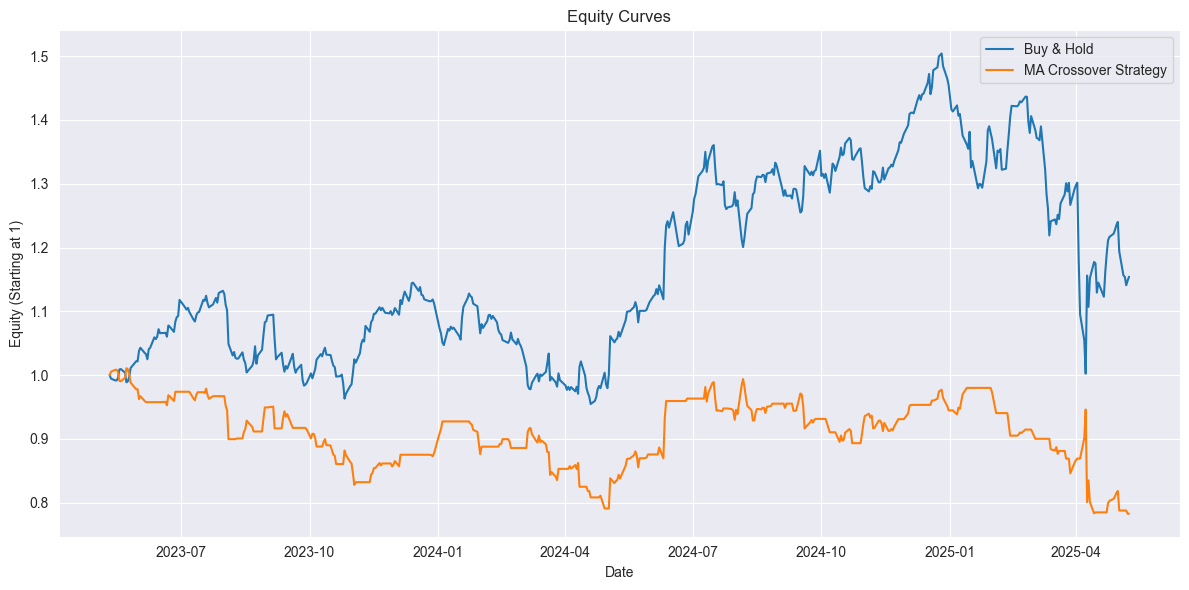

In [19]:
def plot_strategy_results(df):
    # Create a figure with single plot for equity curves
    plt.figure(figsize=(12, 6))

    # Plot equity curves
    plt.plot(df.index, df['buy_hold_equity'], label='Buy & Hold')
    plt.plot(df.index, df['strategy_equity'], label='MA Crossover Strategy')
    plt.title('Equity Curves')
    plt.ylabel('Equity (Starting at 1)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

result_df = analyze_ma_crossover_strategy(TICKER, fast_window=5, slow_window=15, from_date=from_date, to_date=to_date, strategy_type="LONGSHORT")
plot_strategy_results(result_df)

# Testing Alternative Strategy Parameters
### Testing the "ALWAYSLONG_OUTWHEN_NEGSENT" strategy with different moving average windows.


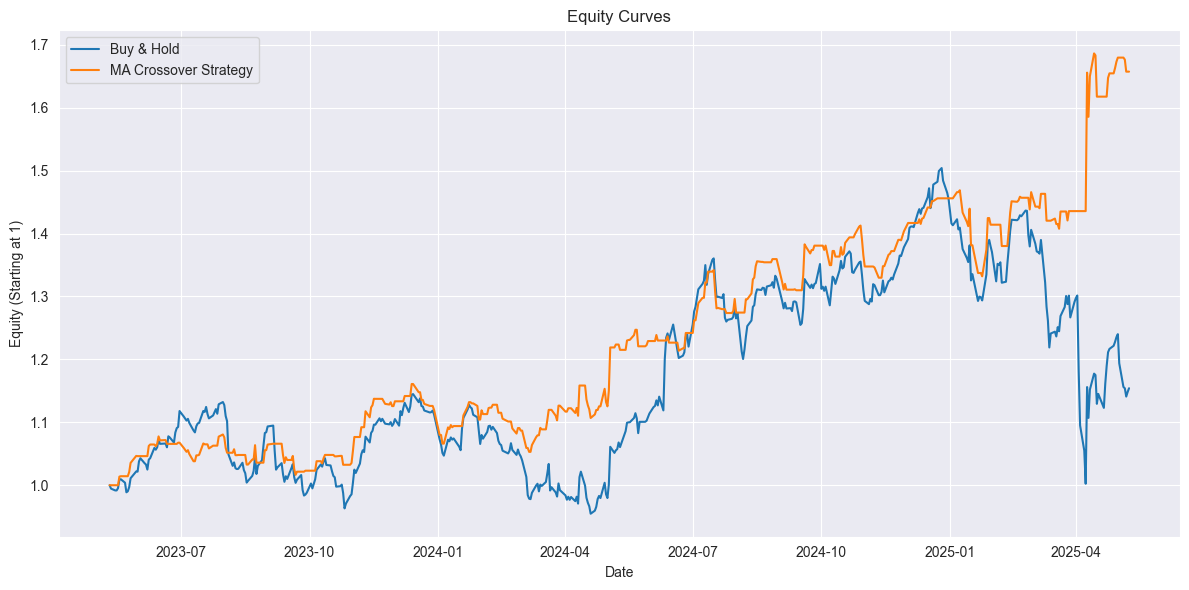

In [20]:
result_df = analyze_ma_crossover_strategy(TICKER, fast_window=1, slow_window=5, from_date=from_date, to_date=to_date, strategy_type="ALWAYSLONG_OUTWHEN_NEGSENT")
plot_strategy_results(result_df)

# Parameter Optimization Across Multiple Stocks
### Finding the best strategy parameters for each ticker by testing various moving average window combinations.


In [21]:
tickers = ['AAPL.US', 'MSFT.US', 'NVDA.US', 'GOOGL.US', 'META.US', 'AMZN.US', 'TSLA.US', 'HD.US', 'JNJ.US', 'UNH.US', 'PFE.US', 'MRK.US', 'JPM.US', 'V.US', 'MA.US', 'PG.US', 'KO.US', 'PEP.US', 'XOM.US', 'CVX.US', 'NEE.US', 'DUK.US', 'LIN.US', 'BA.US', 'CAT.US', 'RTX.US', 'SPG.US', 'AMT.US', 'MO.US']
# Create lists to store the data
data = []
fast_windows = range(1, 6)  # 1 to 5
slow_windows = range(5, 21, 5)  # 5, 10, 15, 20

# Loop through each ticker
for ticker in tickers:
    # Initialize variables to track the best parameters and results for this ticker
    best_fast_window = None
    best_slow_window = None
    best_strategy_type = None
    best_return = -float('inf')
    best_buy_hold_return = None

    # Rest of the loop logic remains the same...
    for fast_window in fast_windows:
        for slow_window in slow_windows:
            for strategy_type in ["LONGSHORT", "ALWAYSLONG_OUTWHEN_NEGSENT"]:
                if fast_window >= slow_window:
                    continue

                result_df = analyze_ma_crossover_strategy(ticker, fast_window, slow_window,
                                                          from_date=from_date, to_date=to_date,
                                                          strategy_type=strategy_type)

                if result_df is not None:
                    strategy_return = result_df['strategy_equity'].iloc[-1]
                    buy_hold_return = result_df['buy_hold_equity'].iloc[-1]

                    if strategy_return > best_return:
                        best_return = strategy_return
                        best_fast_window = fast_window
                        best_slow_window = slow_window
                        best_strategy_type = strategy_type
                        best_buy_hold_return = buy_hold_return

    # Instead of concatenating each time, append to the list
    data.append({
        'ticker': ticker,
        'fast_window': best_fast_window,
        'slow_window': best_slow_window,
        'strategy_type': best_strategy_type,
        'strategy_return': best_return,
        'buy_hold_return': best_buy_hold_return
    })

# Create the DataFrame once with all the data
optimal_params_df = pd.DataFrame(data)
optimal_params_df['str_bnh_diff'] = optimal_params_df['strategy_return'] - optimal_params_df['buy_hold_return']
optimal_params_df

,ticker,fast_window,slow_window,strategy_type,strategy_return,buy_hold_return,str_bnh_diff
0,AAPL.US,1,5,ALWAYSLONG_OUTWHEN_NEGSENT,1.657374,1.154142,0.503233
1,MSFT.US,4,15,ALWAYSLONG_OUTWHEN_NEGSENT,1.423505,1.437257,-0.013752
2,NVDA.US,2,5,ALWAYSLONG_OUTWHEN_NEGSENT,4.230009,4.084455,0.145554
3,GOOGL.US,1,5,ALWAYSLONG_OUTWHEN_NEGSENT,1.553811,1.316637,0.237174
4,META.US,1,5,ALWAYSLONG_OUTWHEN_NEGSENT,1.801456,2.524630,-0.723174
5,AMZN.US,1,5,ALWAYSLONG_OUTWHEN_NEGSENT,1.553281,1.720984,-0.167703
6,TSLA.US,2,5,ALWAYSLONG_OUTWHEN_NEGSENT,2.008487,1.733264,0.275224
7,HD.US,1,15,LONGSHORT,1.307493,1.326410,-0.018917
8,JNJ.US,5,10,LONGSHORT,1.185573,1.019086,0.166487
9,UNH.US,4,5,LONGSHORT,1.338395,0.803416,0.534980


# Visualizing Strategy Performance Across Tickers
### Comparing strategy returns against buy-and-hold returns for each stock using horizontal bar charts.


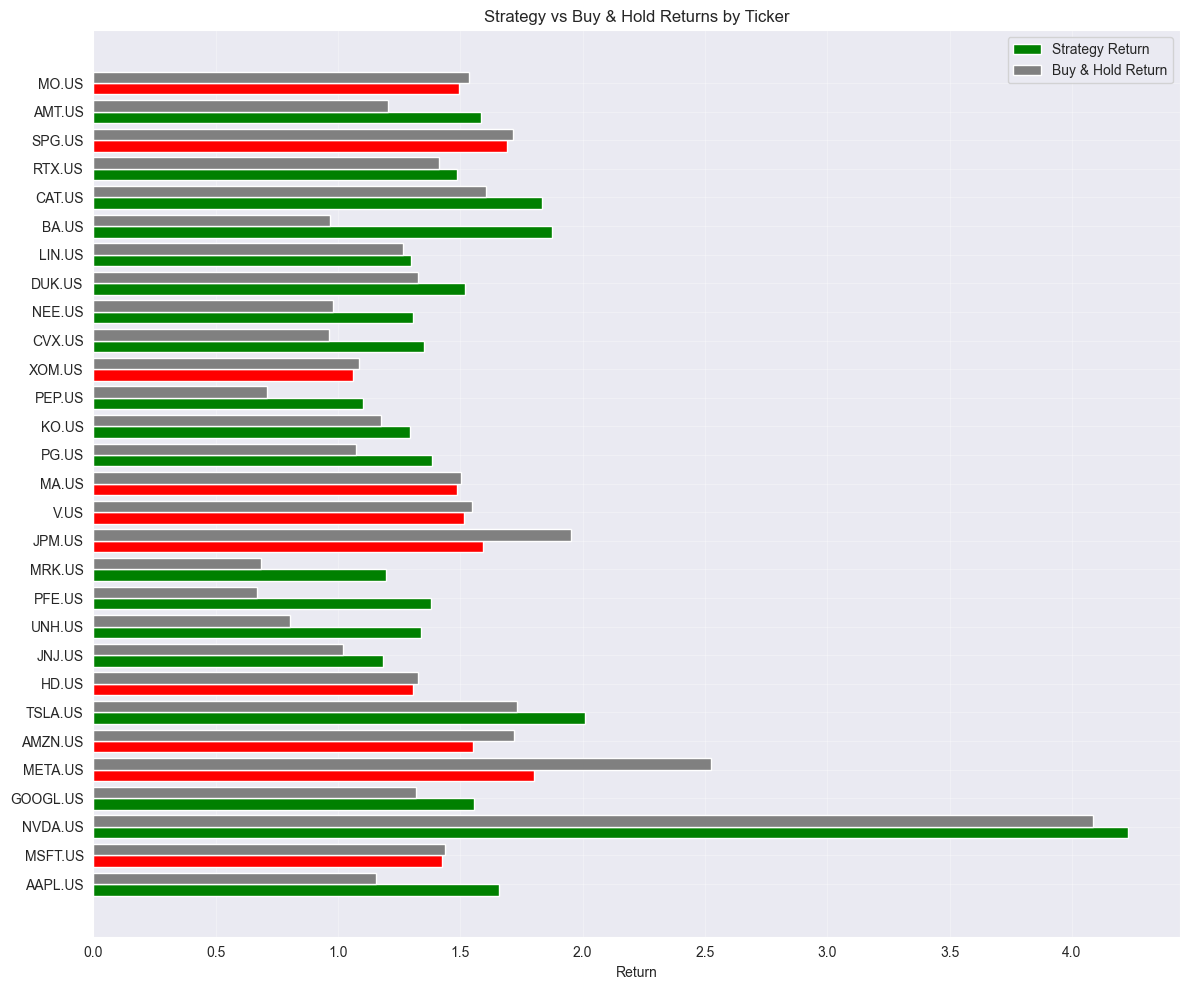

In [22]:
plt.figure(figsize=(12, 10))

# Create horizontal bar positions
y_pos = np.arange(len(optimal_params_df))

# Create color array for strategy returns based on comparison with buy & hold
strategy_colors = ['green' if s > b else 'red' for s, b in zip(optimal_params_df['strategy_return'], optimal_params_df['buy_hold_return'])]

# Plot the bars with new colors
plt.barh(y_pos - 0.2, optimal_params_df['strategy_return'], height=0.4, label='Strategy Return', color=strategy_colors)
plt.barh(y_pos + 0.2, optimal_params_df['buy_hold_return'], height=0.4, label='Buy & Hold Return', color='grey')

plt.yticks(y_pos, optimal_params_df['ticker'])
plt.xlabel('Return')
plt.title('Strategy vs Buy & Hold Returns by Ticker')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comprehensive Parameter Testing
### Testing all combinations of fast/slow windows and strategy types to identify optimal parameters across stocks.


In [23]:
tickers = ['AAPL.US', 'MSFT.US', 'NVDA.US', 'GOOGL.US', 'META.US', 'AMZN.US', 'TSLA.US', 'HD.US', 'JNJ.US', 'UNH.US', 'PFE.US', 'MRK.US', 'JPM.US', 'V.US', 'MA.US', 'PG.US', 'KO.US', 'PEP.US', 'XOM.US', 'CVX.US', 'NEE.US', 'DUK.US', 'LIN.US', 'BA.US', 'CAT.US', 'RTX.US', 'SPG.US', 'AMT.US', 'MO.US']
# Create lists to store the data
data = []
fast_windows = range(1, 6)  # 1 to 5
slow_windows = range(5, 21, 5)  # 5, 10, 15, 20

# Loop through each ticker
for ticker in tickers:
    # Initialize variables to track the best parameters and results for this ticker
    best_fast_window = None
    best_slow_window = None
    best_strategy_type = None
    best_return = -float('inf')
    best_buy_hold_return = None

    # Rest of the loop logic remains the same...
    for fast_window in fast_windows:
        for slow_window in slow_windows:
            for strategy_type in ["LONGSHORT", "ALWAYSLONG_OUTWHEN_NEGSENT"]:
                if fast_window >= slow_window:
                    continue

                result_df = analyze_ma_crossover_strategy(ticker, fast_window, slow_window,
                                                          from_date=from_date, to_date=to_date,
                                                          strategy_type=strategy_type)

                if result_df is not None:
                    strategy_return = result_df['strategy_equity'].iloc[-1]
                    buy_hold_return = result_df['buy_hold_equity'].iloc[-1]

                    data.append({
                        'ticker': ticker,
                        'fast_window': fast_window,
                        'slow_window': slow_window,
                        'strategy_type': strategy_type,
                        'strategy_return': strategy_return,
                        'buy_hold_return': buy_hold_return
                    })

# Create the DataFrame once with all the data
all_runs_df = pd.DataFrame(data)
all_runs_df['str_bnh_diff'] = optimal_params_df['strategy_return'] - optimal_params_df['buy_hold_return']


# Heatmap Analysis of Parameter Performance
### Visualizing average strategy performance across different moving average window combinations using a heatmap.


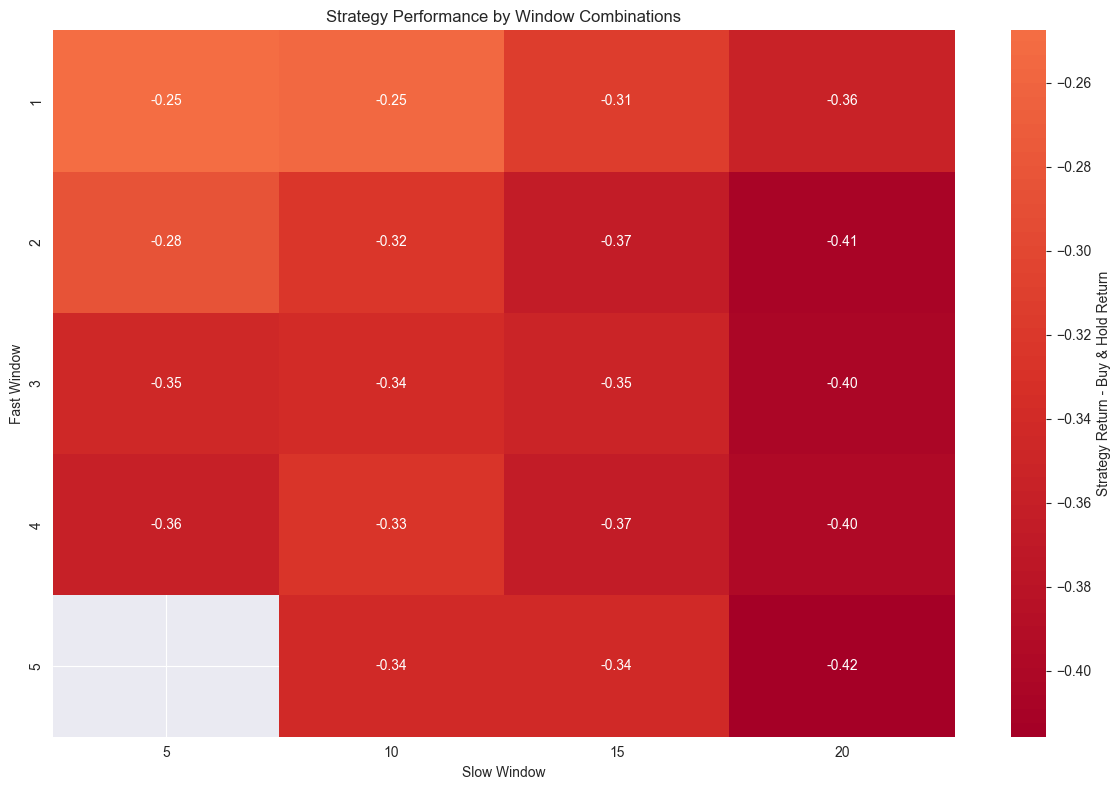

In [24]:
# First, let's create the aggregated data
grouped_df = all_runs_df.groupby(['fast_window', 'slow_window', 'strategy_type']).agg({
    'strategy_return': 'mean',
    'buy_hold_return': 'mean',
}).reset_index()

# Calculate the difference for coloring
grouped_df['str_bnh_diff'] = grouped_df['strategy_return'] - grouped_df['buy_hold_return']

plt.figure(figsize=(12, 8))

# Pivot the data to create a matrix suitable for heatmap
heatmap_data = grouped_df.pivot_table(
    index='fast_window',
    columns='slow_window',
    values='str_bnh_diff',
    aggfunc='mean'
)

# Create heatmap
sns.heatmap(heatmap_data,
            annot=True,
            fmt='.2f',
            cmap='RdYlGn',
            center=0,
            cbar_kws={'label': 'Strategy Return - Buy & Hold Return'}
            )

plt.title('Strategy Performance by Window Combinations')
plt.xlabel('Slow Window')
plt.ylabel('Fast Window')
plt.tight_layout()
plt.show()
